In [102]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import joblib

In [103]:
df = pd.read_csv(r'../data/churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [104]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [105]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


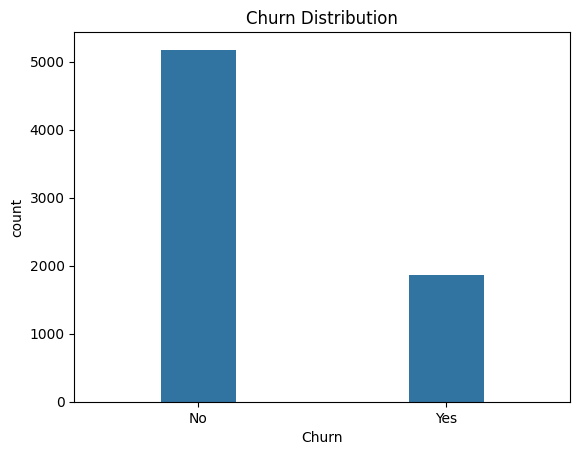

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64


In [106]:
sns.countplot(x='Churn', data=df, width=0.3)
plt.title('Churn Distribution')
plt.show()

counts = df['Churn'].value_counts()
percent = (counts/counts.sum()) *100
print(percent)

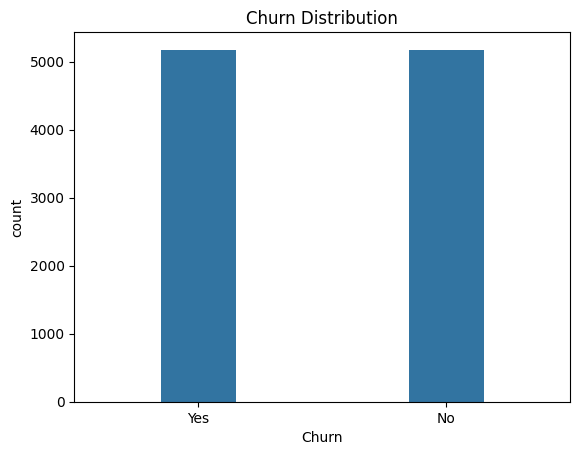

Churn
Yes    50.0
No     50.0
Name: count, dtype: float64


In [107]:
# Resampling the data
df_majority = df[df['Churn']=="No"]
df_minority = df[df['Churn']=='Yes']

df_minority_upsample = resample(df_minority, replace=True, n_samples = len(df_majority), random_state=123)
df_upsampled = pd.concat([df_minority_upsample,df_majority])

sns.countplot(x='Churn',data=df_upsampled,width=0.3)
plt.title('Churn Distribution')
plt.show()

counts = df_upsampled['Churn'].value_counts()
percent = (counts/counts.sum()) *100
print(percent)

In [108]:
df = df_upsampled # re-assigning the df
df = df.drop(['customerID','gender', 'SeniorCitizen', 'Partner', 'Dependents'], axis=1)

In [109]:
df.columns

Index(['tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [110]:
def mapping_cols(df,columns):
    mapping = {'Yes' : 2, 'No':1, 'No internet service': 0, 'No phone service':0}
    for col in columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.strip().str.capitalize()
        df[col]=df[col].map(mapping)
    return df

columns=['PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies','PaperlessBilling']

df_map = mapping_cols(df,columns)


In [111]:
df_map['TotalCharges'] = df_map['TotalCharges'].replace(' ', pd.NA)
df_map.dropna(subset = ['TotalCharges'], inplace = True)

In [112]:
# Changing d-type of other columns
df_map['TotalCharges'] = df_map['TotalCharges'].astype('float64')
df_map['MonthlyCharges'] = df_map['MonthlyCharges'].astype('float64')

In [113]:
# One hot encoding the Contract and Payment methods
def one_hot(df,columns):
    df_encoded = pd.get_dummies(df[columns])
    df_encoded = df_encoded.astype(int)
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=columns, inplace=True)  
    return df

columns = ['Contract', 'PaymentMethod', 'InternetService']
df_map = one_hot(df_map,columns)


In [114]:
df_map.head()

,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No
5812,1,2,1,1,1,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
5306,19,2,2,1,1,1,1,1,2,2,...,1,0,0,0,0,1,0,0,1,0
5368,3,2,1,1,1,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
5125,11,2,2,1,1,1,1,2,2,2,...,1,0,0,0,0,1,0,0,1,0
4273,31,2,2,1,1,1,2,1,1,2,...,1,0,0,0,1,0,0,0,1,0


In [115]:
X = df_map.drop(['Churn'], axis=1)
y = df_map['Churn']
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

In [116]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [117]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [118]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [119]:
#model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

Random Forest Model Accuracy: 90.09%


In [120]:
# saving the model
joblib.dump(model, 'rf_model.pkl')

['rf_model.pkl']